In [37]:
pip install -q plot-keras-history

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.5/322.5 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


In [38]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf

from numpy import mean
from numpy import std
import matplotlib.pyplot as plt

# https://pypi.org/project/plot-keras-history/
from plot_keras_history import show_history, plot_history

#  Import and read the charity_data.csv.
import pandas as pd
application_df = pd.read_csv("https://static.bc-edx.com/data/dl-1-2/m21/lms/starter/charity_data.csv")

In [39]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
application_df = application_df.drop(columns=['EIN'])
application_df.head()

,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [40]:
application_df.value_counts()
# there are a lot of repetitive funding requests

NAME                                                            APPLICATION_TYPE  AFFILIATION       CLASSIFICATION  USE_CASE      ORGANIZATION  STATUS  INCOME_AMT   SPECIAL_CONSIDERATIONS  ASK_AMT  IS_SUCCESSFUL
PARENT BOOSTER USA INC                                          T3                CompanySponsored  C2100           Preservation  Trust         1       0            N                       5000     0                887
TOPS CLUB INC                                                   T3                CompanySponsored  C1200           Preservation  Association   1       0            N                       5000     0                672
UNITED STATES BOWLING CONGRESS INC                              T3                CompanySponsored  C1000           Preservation  Trust         1       0            N                       5000     0                583
AMATEUR ATHLETIC UNION OF THE UNITED STATES INC                 T3                CompanySponsored  C1200           Preservation  T

In [41]:
application_df.query('NAME == "PARENT BOOSTER USA INC"')

,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
158,PARENT BOOSTER USA INC,T3,CompanySponsored,C2100,Preservation,Trust,1,0,N,5000,0
185,PARENT BOOSTER USA INC,T3,CompanySponsored,C2100,Preservation,Trust,1,0,N,5000,0
667,PARENT BOOSTER USA INC,T3,CompanySponsored,C2100,Preservation,Trust,1,25000-99999,N,9206,0
881,PARENT BOOSTER USA INC,T3,CompanySponsored,C2100,Preservation,Trust,1,0,N,5000,0
1805,PARENT BOOSTER USA INC,T3,CompanySponsored,C2100,Preservation,Trust,1,0,N,5000,0
...,...,...,...,...,...,...,...,...,...,...,...
31484,PARENT BOOSTER USA INC,T3,CompanySponsored,C2100,Preservation,Trust,1,0,N,5000,0
31488,PARENT BOOSTER USA INC,T3,CompanySponsored,C2100,Preservation,Trust,1,0,N,5000,1
31499,PARENT BOOSTER USA INC,T3,CompanySponsored,C2100,Preservation,Trust,1,0,N,5000,0
31859,PARENT BOOSTER USA INC,T3,CompanySponsored,C2100,Preservation,Trust,1,0,N,5000,1


In [42]:
# when checking the max value to change bins, I found a massive outlier - 8.6 billion dollars!
print(application_df['ASK_AMT'].max())
print(application_df['ASK_AMT'].count())

8597806340
34299


In [43]:
# eliminate outliers from ask_amt

# get list of ask amounts
data = application_df['ASK_AMT']

# use numpy to calculate mean and std
# https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/
data_mean, data_std = mean(data), std(data)
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off

outliers = [x for x in data if x < lower or x > upper] # list of int
print('Identified outliers: %d' % len(outliers))

# remove indexes where outliers exist
index_list = [] # list of pandas.core.indexes.numeric.Int64Index
for outlier in outliers:
  index_list.append(application_df.index[application_df['ASK_AMT'] == outlier])

index_list

index_int_list = []
for index in index_list:
  temp_index = index[0]
  index_int_list.append(temp_index)

application_df = application_df.drop(index=index_int_list)


  # this cell took WAY too long to figure out, mostly due to difficulties with the Int64Index datatype
  # I'm sure there's a cleaner way to present this code but it works right now so it's staying like this
  # It also has basically no impact on the accuracy

Identified outliers: 53


In [44]:
print(application_df['ASK_AMT'].max())
print(application_df['ASK_AMT'].count())

261164561
34246


In [45]:
# Choose a cutoff value and create a list of names to be replaced use the variable name `names_to_replace`
names_to_replace = application_df['NAME'].value_counts()[application_df['NAME'].value_counts() <= 10].index

# use the list to replace data
for app in names_to_replace:
    application_df['NAME'] = application_df['NAME'].replace(app,"Other")

In [46]:
# Choose a cutoff value and create a list of application types to be replaced use the variable name `application_types_to_replace`
application_types_to_replace = application_df['APPLICATION_TYPE'].value_counts()[application_df['APPLICATION_TYPE'].value_counts() <= 100].index

# use the list to replace data
for app in application_types_to_replace:
    application_df['APPLICATION_TYPE'] = application_df['APPLICATION_TYPE'].replace(app,"Other")

In [47]:
# Choose a cutoff value and create a list of application types to be replaced use the variable name `application_types_to_replace`
classifications_to_replace = application_df['CLASSIFICATION'].value_counts()[application_df['CLASSIFICATION'].value_counts() <= 1].index

# use the list to replace data
for app in classifications_to_replace:
    application_df['CLASSIFICATION'] = application_df['CLASSIFICATION'].replace(app,"Other")

In [48]:
# Split preprocessed data into features and target arrays
y = application_df['IS_SUCCESSFUL']
X_optimized = application_df.drop(columns=['IS_SUCCESSFUL',])

# get_dummies
X_optimized_dummies = pd.get_dummies(X_optimized)

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X_optimized_dummies, y)

In [49]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [50]:
nn_optimized = tf.keras.models.Sequential()
# input and hidden layers
nn_optimized.add(tf.keras.layers.Dense(units=50, input_dim=289, activation='relu'))
nn_optimized.add(tf.keras.layers.Dense(units=25, activation='relu'))
# output
nn_optimized.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Check the structure of the model
#nn_optimized.summary()

In [51]:
nn_optimized.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
trainedOptimizedModel = nn_optimized.fit(X_train_scaled, y_train, epochs=100)

Epoch 1/100
803/803 [==============================] - 3s 3ms/step - loss: 0.4844 - accuracy: 0.7646
Epoch 2/100
803/803 [==============================] - 2s 2ms/step - loss: 0.4458 - accuracy: 0.7828
Epoch 3/100
803/803 [==============================] - 2s 2ms/step - loss: 0.4416 - accuracy: 0.7832
Epoch 4/100
803/803 [==============================] - 2s 2ms/step - loss: 0.4393 - accuracy: 0.7854
Epoch 5/100
803/803 [==============================] - 2s 2ms/step - loss: 0.4375 - accuracy: 0.7861
Epoch 6/100
803/803 [==============================] - 2s 2ms/step - loss: 0.4365 - accuracy: 0.7862
Epoch 7/100
803/803 [==============================] - 2s 3ms/step - loss: 0.4353 - accuracy: 0.7871
Epoch 8/100
803/803 [==============================] - 2s 2ms/step - loss: 0.4344 - accuracy: 0.7871
Epoch 9/100
803/803 [==============================] - 2s 2ms/step - loss: 0.4334 - accuracy: 0.7885
Epoch 10/100
803/803 [==============================] - 2s 2ms/step - loss: 0.4331 - accura

In [52]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_optimized.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 1s - loss: 0.4800 - accuracy: 0.7819 - 501ms/epoch - 2ms/step
Loss: 0.4800417721271515, Accuracy: 0.7819435000419617


In [53]:
nn_optimized.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 50)                14500     
                                                                 
 dense_7 (Dense)             (None, 25)                1275      
                                                                 
 dense_8 (Dense)             (None, 1)                 26        
                                                                 
Total params: 15801 (61.72 KB)
Trainable params: 15801 (61.72 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


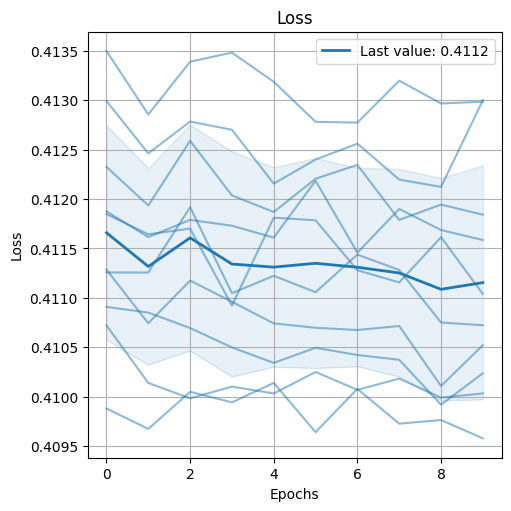

In [54]:
# create charts that show ten iterations of the first ten epochs
# need to create a 'plots' folder first
histories = []
for holdout in range(10):
    model = nn_optimized
    histories.append(model.fit(X_train_scaled, y_train, epochs=10, verbose=0))

plot_history(
    histories,
    path='plots',
    single_graphs=True,
    show_standard_deviation=True,
    show_average=False
)

plt.close()

In [55]:
# Export model to HDF5 file
nn_optimized.save('AlphabetSoupCharity_Optimization', save_format='h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
